In [ ]:
from tqdm.notebook import tqdm
from torch import optim
from torchvision import transforms
import pickle
import torchvision.transforms as tt
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import PIL.Image
from torchvision.transforms.functional import pil_to_tensor
from torch.nn.functional import cosine_similarity, mse_loss
from PIL import Image
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

if not torch.cuda.is_available():
	raise RuntimeError("This model requires GPU to be available")
# @markdown #ArcFace IR_SE_50 Architecture
# ArcFace helper functions
from collections import namedtuple
class Bottleneck(namedtuple('Block', ['in_channel', 'depth', 'stride'])):
	""" A named tuple describing a ResNet block. """

def l2_norm(input, axis=1):
	norm = torch.norm(input, 2, axis, True)
	output = torch.div(input, norm)
	return output

def get_block(in_channel, depth, num_units, stride=2):
	return [Bottleneck(in_channel, depth, stride)] + [Bottleneck(depth, depth, 1) for i in range(num_units - 1)]


def get_blocks(num_layers):
	if num_layers == 50:
		blocks = [
			get_block(in_channel=64, depth=64, num_units=3),
			get_block(in_channel=64, depth=128, num_units=4),
			get_block(in_channel=128, depth=256, num_units=14),
			get_block(in_channel=256, depth=512, num_units=3)
		]
	elif num_layers == 100:
		blocks = [
			get_block(in_channel=64, depth=64, num_units=3),
			get_block(in_channel=64, depth=128, num_units=13),
			get_block(in_channel=128, depth=256, num_units=30),
			get_block(in_channel=256, depth=512, num_units=3)
		]
	elif num_layers == 152:
		blocks = [
			get_block(in_channel=64, depth=64, num_units=3),
			get_block(in_channel=64, depth=128, num_units=8),
			get_block(in_channel=128, depth=256, num_units=36),
			get_block(in_channel=256, depth=512, num_units=3)
		]
	else:
		raise ValueError("Invalid number of layers: {}. Must be one of [50, 100, 152]".format(num_layers))
	return blocks

class SEModule(nn.Module):
	def __init__(self, channels, reduction):
		super(SEModule, self).__init__()
		self.avg_pool = nn.AdaptiveAvgPool2d(1)
		self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1, padding=0, bias=False)
		self.relu = nn.ReLU(inplace=True)
		self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1, padding=0, bias=False)
		self.sigmoid = nn.Sigmoid()

	def forward(self, x):
		module_input = x
		x = self.avg_pool(x)
		x = self.fc1(x)
		x = self.relu(x)
		x = self.fc2(x)
		x = self.sigmoid(x)
		return module_input * x


class bottleneck_IR(nn.Module):
	def __init__(self, in_channel, depth, stride):
		super(bottleneck_IR, self).__init__()
		if in_channel == depth:
			self.shortcut_layer = nn.MaxPool2d(1, stride)
		else:
			self.shortcut_layer = nn.Sequential(
				nn.Conv2d(in_channel, depth, (1, 1), stride, bias=False),
				nn.BatchNorm2d(depth)
			)
		self.res_layer = nn.Sequential(
			nn.BatchNorm2d(in_channel),
			nn.Conv2d(in_channel, depth, (3, 3), (1, 1), 1, bias=False), nn.PReLU(depth),
			nn.Conv2d(depth, depth, (3, 3), stride, 1, bias=False), nn.BatchNorm2d(depth)
		)

	def forward(self, x):
		shortcut = self.shortcut_layer(x)
		res = self.res_layer(x)
		return res + shortcut


class bottleneck_IR_SE(nn.Module):
	def __init__(self, in_channel, depth, stride):
		super(bottleneck_IR_SE, self).__init__()
		if in_channel == depth:
			self.shortcut_layer = nn.MaxPool2d(1, stride)
		else:
			self.shortcut_layer = nn.Sequential(
				nn.Conv2d(in_channel, depth, (1, 1), stride, bias=False),
				nn.BatchNorm2d(depth)
			)
		self.res_layer = nn.Sequential(
			nn.BatchNorm2d(in_channel),
			nn.Conv2d(in_channel, depth, (3, 3), (1, 1), 1, bias=False),
			nn.PReLU(depth),
			nn.Conv2d(depth, depth, (3, 3), stride, 1, bias=False),
			nn.BatchNorm2d(depth),
			SEModule(depth, 16)
		)

	def forward(self, x):
		shortcut = self.shortcut_layer(x)
		res = self.res_layer(x)
		return res + shortcut

class Backbone(nn.Module):
	def __init__(self, input_size, num_layers, mode='ir_se', drop_ratio=0.6, affine=True):
		super(Backbone, self).__init__()
		assert input_size in [112, 224], "input_size should be 112 or 224"
		assert num_layers in [50, 100, 152], "num_layers should be 50, 100 or 152"
		assert mode in ['ir', 'ir_se'], "mode should be ir or ir_se"
		blocks = get_blocks(num_layers)
		if mode == 'ir':
			unit_module = bottleneck_IR
		elif mode == 'ir_se':
			unit_module = bottleneck_IR_SE
		self.input_layer = nn.Sequential(nn.Conv2d(3, 64, (3, 3), 1, 1, bias=False),
									  nn.BatchNorm2d(64),
									  nn.PReLU(64))
		if input_size == 112:
			self.output_layer = nn.Sequential(nn.BatchNorm2d(512),
			                               nn.Dropout(drop_ratio),
			                               nn.Flatten(),
			                               nn.Linear(512 * 7 * 7, 512),
			                               nn.BatchNorm1d(512, affine=affine))
		else:
			self.output_layer = nn.Sequential(nn.BatchNorm2d(512),
			                               nn.Dropout(drop_ratio),
			                               nn.Flatten(),
			                               nn.Linear(512 * 14 * 14, 512),
			                               nn.BatchNorm1d(512, affine=affine))

		modules = []
		for block in blocks:
			for bottleneck in block:
				modules.append(unit_module(bottleneck.in_channel,
										   bottleneck.depth,
										   bottleneck.stride))
		self.body = nn.Sequential(*modules)

	def forward(self, x, multi_scale=False):
		x = self.input_layer(x)

		if multi_scale:
			# extract multi scale features
			modulelist = list(self.body._modules.values())
			for i, l in enumerate(modulelist):
				x = l(x)
				if i == 2:
					c1 = x.view(x.size(0), -1)
				elif i==6:
					c2 = x.view(x.size(0), -1)
				elif i == 20:
					c3 = x.view(x.size(0), -1)
				elif i == 23:
					c4 = x.view(x.size(0), -1)
		else:
			# extract only the final layer's feature
			x = self.body(x)

		x = self.output_layer(x)

		if multi_scale:
			return [l2_norm(c1),l2_norm(c2),l2_norm(c3),l2_norm(c4),l2_norm(x)]
		else:
			return [l2_norm(x)]

def IR_SE_50(input_size):
	"""Constructs a ir_se-50 model."""
	model = Backbone(input_size, num_layers=50, mode='ir_se', drop_ratio=0.4, affine=False)
	return model

In [ ]:
# @markdown #Setup Dependencies
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# clone main repository
!git clone https://github.com/Viktor-Sok/Image_Editing_StyleCLIP_Optimization.git;
!unzip /content/Image_Editing_StyleCLIP_Optimization/assets/torch_utils.zip -d /content;
!unzip /content/Image_Editing_StyleCLIP_Optimization/assets/dnnlib.zip -d /content;
!mv /content/Image_Editing_StyleCLIP_Optimization/assets/legacy.py /content;
!mv /content/Image_Editing_StyleCLIP_Optimization/test_images /content
with open("/content/test_images/style_vecs.pickle", 'rb') as f1, open("/content/test_images/z_vecs.pickle", 'rb') as f2:
    style_vecs = pickle.load(f1)
    z_vecs =  pickle.load(f2)

# StyleGAN:  https://github.com/NVlabs/stylegan2-ada-pytorch
%pip install ninja;
import dnnlib
import legacy

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema'].requires_grad_(False).to(device)

# CLIP model: https://github.com/openai/CLIP
%pip install git+https://github.com/openai/CLIP.git
import clip
model, preprocess = clip.load("ViT-B/32", device=device)

# ArcFace: https://medium.com/@ichigo.v.gen12/arcface-architecture-and-practical-example-how-to-calculate-the-face-similarity-between-images-183896a35957
arcface = Backbone(input_size=112, num_layers=50, drop_ratio=0.6, mode='ir_se')
!pip install gdown;
!gdown --id  1a1lx5qlxeqxDm94C36nsSDfQu-WZOaIw; # weights for ArcFace
checkpoints = torch.load("/content/model_ir_se50.pth", map_location = device)
arcface.load_state_dict(checkpoints)


fatal: destination path 'Image_Editing_StyleCLIP_Optimization' already exists and is not an empty directory.
Archive:  /content/Image_Editing_StyleCLIP_Optimization/assets/torch_utils.zip
replace /content/torch_utils/custom_ops.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: Archive:  /content/Image_Editing_StyleCLIP_Optimization/assets/dnnlib.zip
replace /content/dnnlib/util.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: mv: cannot stat '/content/Image_Editing_StyleCLIP_Optimization/assets/legacy.py': No such file or directory
mv: cannot stat '/content/Image_Editing_StyleCLIP_Optimization/test_images': No such file or directory
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-ms36lers
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-ms36lers
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
/usr/local/lib/python3.10/dist-packages/gd

<All keys matched successfully>

In [ ]:
# @markdown # Helper functions
# def styleGAN_show_img(img):
#     fig, ax = plt.subplots(figsize=(8, 8))
#     ax.set_xticks([]); ax.set_yticks([])
#     img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
#     pil_img = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')
#     ax.imshow(pil_img)
#     plt.show()
from torchvision.transforms.functional import to_pil_image
def styleGAN_show_img(img, size = 2):
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    plt.figure(figsize=(size, size))
    plt.imshow(img.detach().cpu()[0])
    plt.axis('off')
    plt.show()

def toPIL(img):
    img = (img * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    pil_img = to_pil_image(img)
    return pil_img


def show_img_tensor(img):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(img.squeeze().detach().permute(1, 2, 0))

In [ ]:
# @markdown # CLIP Loss
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize
from torchvision.transforms import InterpolationMode
import clip
from clip import tokenize
class CLIP_StyleGANLoss:
  @staticmethod
  def styleGAN_denorm(img):
      return (img * 0.498 + 0.5).clamp(0.0, 1.0)

  @staticmethod
  def transform_for_CLIP(n_px):
    return Compose([
        CLIP_StyleGANLoss.styleGAN_denorm,
        Resize(n_px, interpolation= InterpolationMode.BICUBIC ),
        CenterCrop(n_px),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])

  @staticmethod
  def tarnsform_for_ArcFace():
    return Compose([
      lambda img: img.squeeze(0),
      CLIP_StyleGANLoss.styleGAN_denorm,
      Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
      lambda img: torch.unsqueeze(img, 0),
      torch.nn.AdaptiveAvgPool2d((112, 112))
    ])

  @staticmethod
  def src_img_transform_ArcFace(img):
    if isinstance(img, torch.Tensor):
        trans = Compose([
          lambda img: img.squeeze(0),
          CLIP_StyleGANLoss.styleGAN_denorm,
          Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
          lambda img: torch.unsqueeze(img, 0),
          torch.nn.AdaptiveAvgPool2d((112, 112))
        ])
    else:
        trans = Compose([
          transforms.ToTensor(),
          Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
          lambda img: torch.unsqueeze(img, 0),
          torch.nn.AdaptiveAvgPool2d((112, 112))
        ])
    return trans(img)

  def __init__(self, styleGAN, clip, arcFace, latent : torch.Tensor, img_src : PIL.Image.Image, text : str,  device, lamL2 = 0.0, lamID = 0.05):
    self.clip = clip.to(device).eval()
    self.arcFace = arcFace.to(device).eval()
    self.styleGAN = styleGAN.to(device).eval()

    for param in self.clip.parameters():
        param.requires_grad = False
    for param in self.arcFace.parameters():
        param.requires_grad = False
    for param in self.styleGAN.parameters():
        param.requires_grad = False

    self.gen_img = None
    self.latent = latent.to(device)
    self.clip_trans = CLIP_StyleGANLoss.transform_for_CLIP(clip.visual.input_resolution)
    self.arcFace_trans = CLIP_StyleGANLoss.tarnsform_for_ArcFace()
    self.arcFace_img_src = self.arcFace(CLIP_StyleGANLoss.src_img_transform_ArcFace(img_src).to(device))[0]
    self.clip_text_embed = clip.encode_text(tokenize(text).to(device))
    self.lamL2 = lamL2
    self.lamID = lamID

  def _clip_loss(self, img):
    clip_img_embed = self.clip.encode_image(self.clip_trans(img))
    return 1.0 - cosine_similarity(clip_img_embed, self.clip_text_embed)

  def _id_loss(self, img):
    arcFace_img = self.arcFace(self.arcFace_trans(img))[0]
    return 1.0 - cosine_similarity(arcFace_img, self.arcFace_img_src)

  def get_img(self):
    if self.gen_img is None:
      raise ValueError('self.gen_img is None')
    return self.gen_img

  def __call__(self, latent):
    if latent.size()[1] == 512:
      w = G.mapping(latent, None)
    else:
      w = latent
    self.gen_img = self.styleGAN.synthesis(w, noise_mode='const')
    return self._clip_loss(self.gen_img) + self.lamL2 * mse_loss(torch.flatten(latent), torch.flatten(self.latent), reduction = "sum")  + self.lamID * self._id_loss(self.gen_img)




In [ ]:
# @markdown # Adam Optimizer
import math
def get_lr(t, initial_lr, rampdown=0.25, rampup=0.05):
    lr_ramp = min(1, (1 - t) / rampdown)
    lr_ramp = 0.5 - 0.5 * math.cos(lr_ramp * math.pi)
    lr_ramp = lr_ramp * min(1, t / rampup)

    return initial_lr * lr_ramp

class AdamOptimizer:
  def set_loss(self, loss):
      self.loss = loss

  def set_params(self, latent_init,  device, *, iter_log = 100, max_steps = 300, verbose = True):
    self.max_steps = max_steps
    self.latent = latent_init.detach().clone().to(device)
    self.latent.requires_grad = True
    self.optim = optim.Adam([self.latent], lr = 1.e-3)
    self.n_iter = iter_log
    self.verbose = verbose

  def run(self):
    for i in tqdm(range(self.max_steps)):
      lr = get_lr(i/self.max_steps, 1.e-3)
      self.optim.param_groups[0]["lr"] = lr
      loss = self.loss(self.latent)
      self.optim.zero_grad()
      loss.backward()
      self.optim.step()
      if self.verbose and (i+1) % self.n_iter == 0:
        print(f"loss: {loss.detach().item()}")
        styleGAN_show_img(self.loss.get_img())



# Set Optimization Options
**l2_lambda:** determines how far we allow to move from original image style vector <br>
**id_lambda:** regulates degree of similarity between original image and generated one

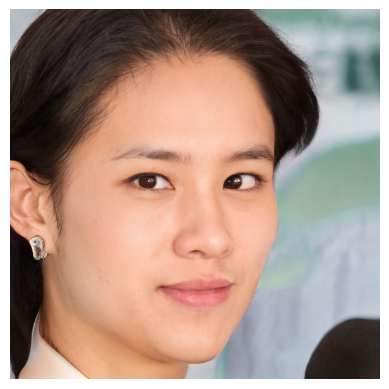

In [ ]:
optimization_space = 'Z Space (512)' #@param ['Z Space (512)', 'W+ Space (512*18)']

description = 'your text promt' #@param {type:"string"}

save_as = 'filename' #@param {type:"string"}

img_number = 11 # @param {type:"slider", min:0, max:14, step:1}

optimization_steps = 3000 #@param {type:"number"}

l2_lambda = 0.001 #@param {type:"number"}

id_lambda = 0.05 #@param {type:"number"}

verbose_optimization= True #@param {type:"boolean"}

# Load image
src_img = PIL.Image.open("/content/test_images/Image_" + str(img_number) + ".bmp").convert('RGB')
plt.imshow(src_img)
plt.axis('off')
plt.show()

# Load image latent vector
if optimization_space == "W+ Space (512*18)":
  latent = style_vecs[img_number].view(1, 18, 512)
else:
  latent = z_vecs[img_number].unsqueeze(0)


In [ ]:
# @markdown #Run Optimization
if latent.size()[1] == 512:
    w = G.mapping(latent.to(device), None)
else:
    w = latent
# We pass src_img generated from save style vecs instead of passing loaded .bmp,
# as it has some discrepancy with style vecs and affect L2 part of the loss

src_img_ = G.synthesis(w.to(device), noise_mode='const')
loss = CLIP_StyleGANLoss(G, model, arcface, latent, src_img_, description, device, l2_lambda, id_lambda)
opt = AdamOptimizer()
opt.set_loss(loss)
opt.set_params(latent, device, max_steps = optimization_steps, verbose = verbose_optimization)
opt.run()

In [ ]:
# @markdown # Visualize and Save Result
if opt.latent.size()[1] == 512:
    latent = G.mapping(opt.latent, None)
else:
  latent = opt.latent
edited_img = G.synthesis(latent, noise_mode='const')
styleGAN_show_img(edited_img, size = 8)
pil_edited_img = toPIL(edited_img.squeeze(0))
pil_edited_img.save(save_as + ".jpg")